# 期末大作业：基于深度学习的细胞类型聚类


成员：张铭徐(2113615) 张惠程(2112241)


## Motivation

现如今二代测序技术可以测得生物体大量的的组学数据信息，如基因组数据、转录组数据以及蛋白组数据，其为了解生物体的调控机理提供了数据基础。然而对于生物数据的标注一直是一个难题，对于转录组数据，其通常是来分析细胞群的marker基因来给细胞群体进行标注，但是这需要耗费大量的人力和财力 。机器学习为生物数据标注提供了很大的便捷，其可以通过一些算法（如最简单的层次聚类、Kmeans等）先为数据标注一个大致正确的伪标签，为后续生物学家进行真实细胞类型的标注提供了参考。
         

## Dataset
我们这次使用转录组数据作为数据集来完成这次任务，转录组数据本质上是一个稀疏矩阵$X$，其大小为$n*m$，$n$代表细胞总数，$m$代表基因表达的数量，其本质是一个基因表达矩阵，$X_{i,j}$代表第$i$个细胞在第$j$个基因上的表达量。此次需要提交一个细胞聚类的编号文件，（聚类编号从0到$k$，$k$为算法计算的$k$个潜在细胞群）。请按照给定的基因表达矩阵的细胞数据顺序提交最后的结果。我们将会用Adjusted Rand Score来评价你的结果。

实验数据：dataset1（无真实标签）、dataset2（有真实细胞类型标签）。

## 要求：

- 基础要求(20)：使用简单的深度学习的方法对数据进行细胞类型聚类，得到多个亚群，完成实验报告（最好使用ipynb文件，包括但不限于代码、模型设计思路、模型架构图、聚类效果展示、实验分析等），并以csv文件提交最终的dataset1数据聚类结果（聚类编号从0到k，k为算法计算的k个潜在细胞群）。

- 中级要求(5)：使用你的方法在dataset2上做实验，dataset2有真实的细胞类型标签，你可以对你的方法进行自我评估，并且分析结果，可以体现你的模型改进过程。展示你计算的Adjusted Rand Score指标。

- 高级要求(5): 使用较为复杂的神经网络进行细胞类型聚类。如复现相关论文，用到你的网络中进行复现等。

- 加分项(5)：基础要求的结果会通过Adjusted Rand Score指标进行评分，排名靠前会有额外得分。

- 注意dataset1和dataset2虽然是同属于转录组数据，但是之间存在批次效应，最好不要考虑参考dataset2的真实标签来调整dataset1的结果。该任务是无监督的聚类任务，其训练集和测试集是一致的，不是传统的需要划分训练、验证和测试集的任务。
         


In [30]:
# 引入头文件
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.engine.topology import Layer
from keras.layers import Lambda
from scipy.optimize import linear_sum_assignment
from keras import backend as K
import tensorflow as tf
import numpy as np
import csv, os
import pickle, os, numbers
import scipy as sp
import pandas as pd
import scanpy.api as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import anndata as ad
from time import time
from keras.models import Model
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, GaussianNoise, Layer, Activation
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn import metrics
import h5py
import scanpy.api as sc
from tensorflow import set_random_seed
from numpy.random import seed
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [31]:
# Load Dataset
rna = ad.read_h5ad("dataset2.h5ad")
adata2 = ad.read_h5ad('dataset2.h5ad')
rna.obs

,domain,cell_type
cells,,
09L_GTTAGAACAGAT_RNA,scRNA-seq,E6Tle4
09I_CATAGCTCAACG_RNA,scRNA-seq,E2Rasgrf2
09G_TTACAGGCAGGT_RNA,scRNA-seq,InP
09B_CTATGGGCGTGC_RNA,scRNA-seq,E4Il1rapl2
09L_AGTGATTGTTCG_RNA,scRNA-seq,Peri
...,...,...
09E_CCTGCTCGTCAC_RNA,scRNA-seq,Peri
09E_TGAGCACCTCCT_RNA,scRNA-seq,E5Parm1
09E_CCGGACTCGATC_RNA,scRNA-seq,E3Rorb


初步可视化如下：
对于Dataset 1：

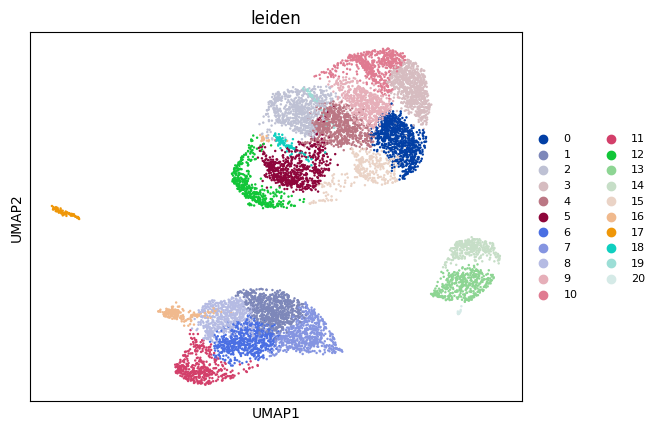

对于Dataset 2：

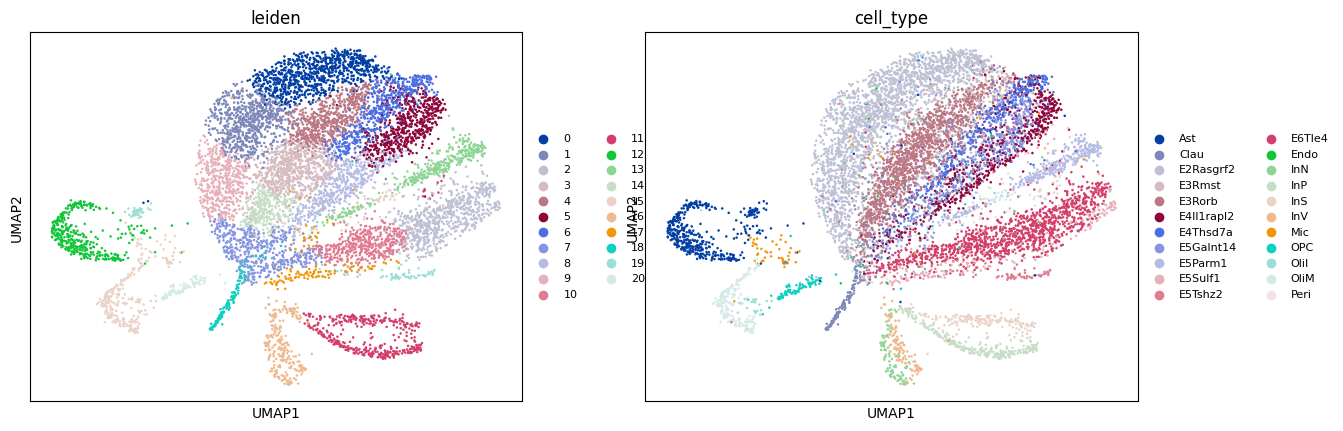


我们可以看到，实际上对于第二个数据集而言，他自带的聚类算法一共聚类了21类，而实际上我们有22个类，相对效果就不是很好了，事实上，我们考虑聚类，聚类的本质是无监督学习，我们通过学习数据的特征分布，将具有相同数据分布的细胞划分为一类，那么我们最重要的事情就是如何学习数据的分布？

我们还有一个问题在于，当前数据是一个稀疏矩阵，稀疏矩阵的规模特别大，是29830这么多，也就是9000多个细胞有接近3w个属性，显然如果属性较多，训练集较少，是根本无法直接进行学习特征的，并且由于矩阵是稀疏的，我们需要进行一些特征工程，提取对应的有效特征后再进行实验，所以我们的根本目标就在于，如何提取大量属性中的关键属性/信息？

一种比较显然的方法是利用主成分分析PCA，先进行一定程度上的数据降维+标准化，我们原本有3w个属性，我们先通过主成分分析近似的筛选出一些类别，减少一些维度后，在考虑一些事情。

事实上，我们最开始在进行初步先验的时候，就是用的类似方法，先对数据进行一些初步的预处理，然后使用自带的聚类方法直接聚类，这种方法很简单粗暴，所以效果不那么好。

我们的更改在于后续考虑引入Deep Learning，Deep Learning方法的好处在于深度神经网络可以有效的学习数据的分布，提取对应的特征，所以我们考虑引入Auto-Encoder。论文《Deep learning-based clustering approaches for bioinformatics》中也提到了Auto-Encoder在处理聚类问题上的优越性，具体来说，我们的思路是，首先我们将数据输入到Auto-Encoder中，由于AE实际上是一个良好的特征学习器，在图像生成等领域具有一些优势，我们通过一系列的层学习到数据的低维分布(特征)，也就是encoder的过程，然后通过decoder解码为原本的数据，通过不断优化decoder的数据和原始数据的差异，最终得到了一个比较不错的特征学习器，我们通过这个低纬度表示，进行聚类分析，就实现了原本的痛点——如何学习到数据的特征并降维

我们考虑复现对应论文《https://www.nature.com/articles/s42256-019-0037-0.》（JCR Q1 Nature Machine Intelligence）

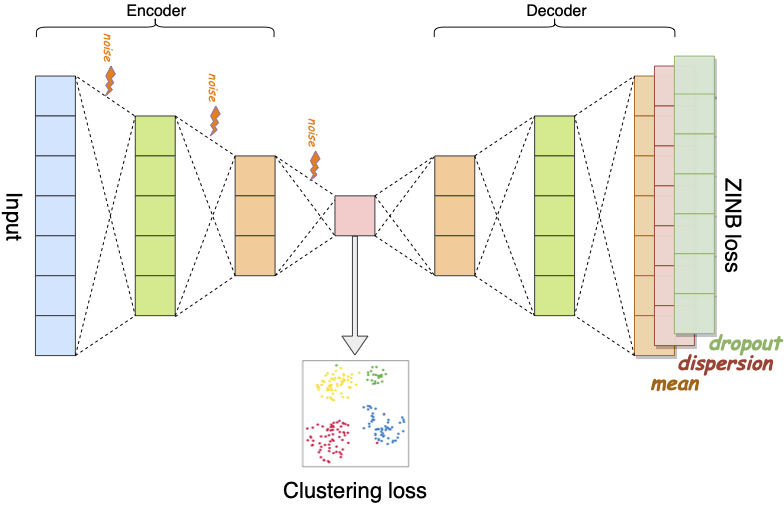

In [32]:
class ConstantDispersionLayer(Layer):
    '''
        An identity layer which allows us to inject extra parameters
        such as dispersion to Keras models
    '''
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.theta = self.add_weight(shape=(1, input_shape[1]),
                                     initializer='zeros',
                                     trainable=True,
                                     name='theta')
        self.theta_exp = tf.clip_by_value(K.exp(self.theta), 1e-3, 1e4)
        super().build(input_shape)

    def call(self, x):
        return tf.identity(x)

    def compute_output_shape(self, input_shape):
        return input_shape


class SliceLayer(Layer):
    def __init__(self, index, **kwargs):
        self.index = index
        super().__init__(**kwargs)

    def build(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('Input should be a list')

        super().build(input_shape)

    def call(self, x):
        assert isinstance(x, list), 'SliceLayer input is not a list'
        return x[self.index]

    def compute_output_shape(self, input_shape):
        return input_shape[self.index]


nan2zeroLayer = Lambda(lambda x: tf.where(tf.is_nan(x), tf.zeros_like(x), x))
ColWiseMultLayer = lambda name: Lambda(lambda l: l[0]*(tf.matmul(tf.reshape(l[1], (-1,1)),
                                                                 tf.ones((1, l[0].get_shape()[1]),
                                                                         dtype=l[1].dtype))),
                                       name=name)

In [33]:
def _nan2zero(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)


def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)


def mse_loss(y_true, y_pred):
    ret = tf.square(y_pred - y_true)

    return _reduce_mean(ret)

def poisson_loss(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    nelem = _nelem(y_true)
    y_true = _nan2zero(y_true)

    ret = y_pred - y_true*tf.log(y_pred+1e-10) + tf.lgamma(y_true+1.0)

    return tf.divide(tf.reduce_sum(ret), nelem)

class NB(object):
    def __init__(self, theta=None, masking=False, scope='nbinom_loss/',
                 scale_factor=1.0, debug=False):

        # for numerical stability
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        self.scope = scope
        self.masking = masking
        self.theta = theta

    def loss(self, y_true, y_pred, mean=True):
        scale_factor = self.scale_factor
        eps = self.eps

        with tf.name_scope(self.scope):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor

            if self.masking:
                nelem = _nelem(y_true)
                y_true = _nan2zero(y_true)

            theta = tf.minimum(self.theta, 1e6)

            t1 = tf.lgamma(theta+eps) + tf.lgamma(y_true+1.0) - tf.lgamma(y_true+theta+eps)
            t2 = (theta+y_true) * tf.log(1.0 + (y_pred/(theta+eps))) + (y_true * (tf.log(theta+eps) - tf.log(y_pred+eps)))

            if self.debug:
                assert_ops = [
                        tf.verify_tensor_all_finite(y_pred, 'y_pred has inf/nans'),
                        tf.verify_tensor_all_finite(t1, 't1 has inf/nans'),
                        tf.verify_tensor_all_finite(t2, 't2 has inf/nans')]

                tf.summary.histogram('t1', t1)
                tf.summary.histogram('t2', t2)

                with tf.control_dependencies(assert_ops):
                    final = t1 + t2

            else:
                final = t1 + t2

            final = _nan2inf(final)

            if mean:
                if self.masking:
                    final = tf.divide(tf.reduce_sum(final), nelem)
                else:
                    final = tf.reduce_mean(final)


        return final

class ZINB(NB):
    def __init__(self, pi, ridge_lambda=0.0, scope='zinb_loss/', **kwargs):
        super().__init__(scope=scope, **kwargs)
        self.pi = pi
        self.ridge_lambda = ridge_lambda

    def loss(self, y_true, y_pred, mean=True):
        scale_factor = self.scale_factor
        eps = self.eps

        with tf.name_scope(self.scope):
            nb_case = super().loss(y_true, y_pred, mean=False) - tf.log(1.0-self.pi+eps)

            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor
            theta = tf.minimum(self.theta, 1e6)

            zero_nb = tf.pow(theta/(theta+y_pred+eps), theta)
            zero_case = -tf.log(self.pi + ((1.0-self.pi)*zero_nb)+eps)
            result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
            ridge = self.ridge_lambda*tf.square(self.pi)
            result += ridge

            if mean:
                if self.masking:
                    result = _reduce_mean(result)
                else:
                    result = tf.reduce_mean(result)

            result = _nan2inf(result)

            if self.debug:
                tf.summary.histogram('nb_case', nb_case)
                tf.summary.histogram('zero_nb', zero_nb)
                tf.summary.histogram('zero_case', zero_case)
                tf.summary.histogram('ridge', ridge)

        return result

我们定义几个损失函数，主要用于深度学习模型，特别是在处理计数数据（如基因表达数据）时。它包括均方误差损失（MSE）、泊松损失（Poisson Loss）、负二项分布损失（Negative Binomial, NB）和零膨胀负二项分布损失（Zero-Inflated Negative Binomial, ZINB）。以下是每部分的具体说明：

### 辅助函数
1. **`_nan2zero`** 和 **`_nan2inf`**：
   - 这些函数用于处理数值稳定性问题。它们将输入中的 NaN 值替换为 0 (`_nan2zero`) 或无穷大 (`_nan2inf`)。

2. **`_nelem`** 和 **`_reduce_mean`**：
   - `_nelem` 计算输入中非 NaN 元素的数量。
   - `_reduce_mean` 计算忽略 NaN 的均值。

### 损失函数
1. **均方误差损失（MSE Loss）** (`mse_loss`)：
   - 用于回归问题。计算预测值 (`y_pred`) 和真实值 (`y_true`) 之间差的平方。

2. **泊松损失（Poisson Loss）** (`poisson_loss`)：
   - 用于计数数据的回归问题。适用于预测事件发生次数，事件在每个区间内发生的概率是固定的且事件之间相互独立。

3. **负二项分布损失（Negative Binomial Loss）** (`NB`)：
   - 负二项分布通常用于描述具有过度离散（over-dispersion）现象的计数数据。它比泊松分布有一个额外的参数（theta）来控制离散度。

4. **零膨胀负二项分布损失（Zero-Inflated Negative Binomial Loss）** (`ZINB`)：
   - 零膨胀模型用于处理具有过多零值的计数数据。它结合了负二项分布和一个用于建模零值的逻辑回归部分。

### 使用场景
这些损失函数特别适用于基因表达数据分析，其中计数数据（如读数或转录本数）是常见的数据类型。这些数据通常呈现出显著的离散度和大量的零值，标准的回归损失函数（如 MSE 或泊松损失）可能不足以有效地建模这些特性。负二项分布和零膨胀负二项分布损失函数提供了更为合适的替代方案。

In [34]:
class AnnSequence:
    def __init__(self, matrix, batch_size, sf=None):
        self.matrix = matrix
        if sf is None:
            self.size_factors = np.ones((self.matrix.shape[0], 1),
                                        dtype=np.float32)
        else:
            self.size_factors = sf
        self.batch_size = batch_size

    def __len__(self):
        return len(self.matrix) // self.batch_size

    def __getitem__(self, idx):
        batch = self.matrix[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_sf = self.size_factors[idx*self.batch_size:(idx+1)*self.batch_size]

        # return an (X, Y) pair
        return {'count': batch, 'size_factors': batch_sf}, batch


def read_dataset(adata, transpose=False, test_split=False, copy=False):

    if isinstance(adata, sc.AnnData):
        if copy:
            adata = adata.copy()
    elif isinstance(adata, str):
        adata = sc.read(adata)

    if adata.X.size < 50e6: 
        if sp.sparse.issparse(adata.X):
            assert (adata.X.astype(int) != adata.X).nnz == 0
        else:
            assert np.all(adata.X.astype(int) == adata.X)

    if transpose: adata = adata.transpose()

    if test_split:
        train_idx, test_idx = train_test_split(np.arange(adata.n_obs), test_size=0.1, random_state=42)
        spl = pd.Series(['train'] * adata.n_obs)
        spl.iloc[test_idx] = 'test'
        adata.obs['DCA_split'] = spl.values
    else:
        adata.obs['DCA_split'] = 'train'

    adata.obs['DCA_split'] = adata.obs['DCA_split'].astype('category')
    print('### Autoencoder: Successfully preprocessed {} genes and {} cells.'.format(adata.n_vars, adata.n_obs))

    return adata


def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):

    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

def read_genelist(filename):
    genelist = list(set(open(filename, 'rt').read().strip().split('\n')))
    assert len(genelist) > 0, 'No genes detected in genelist file'
    print('### Autoencoder: Subset of {} genes will be denoised.'.format(len(genelist)))

    return genelist

def write_text_matrix(matrix, filename, rownames=None, colnames=None, transpose=False):
    if transpose:
        matrix = matrix.T
        rownames, colnames = colnames, rownames

    pd.DataFrame(matrix, index=rownames, columns=colnames).to_csv(filename,
                                                                  sep='\t',
                                                                  index=(rownames is not None),
                                                                  header=(colnames is not None),
                                                                  float_format='%.6f')
def read_pickle(inputfile):
    return pickle.load(open(inputfile, "rb"))

In [35]:
# 随机种子保证结果可复现
seed(2211)
set_random_seed(2211)

MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size


def autoencoder(dims, noise_sd=2.5, init='glorot_uniform', act='relu'):
    n_stacks = len(dims) - 1
    # input
    sf_layer = Input(shape=(1,), name='size_factors')
    x = Input(shape=(dims[0],), name='counts')
    h = x
    h = GaussianNoise(noise_sd, name='input_noise')(h)

    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], kernel_initializer=init, name='encoder_%d' % i)(h)
        h = GaussianNoise(noise_sd, name='noise_%d' % i)(h)
        h = Activation(act)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_hidden')(h)  # hidden layer, features are extracted from here

    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(h)


    pi = Dense(dims[0], activation='sigmoid', kernel_initializer=init, name='pi')(h)

    disp = Dense(dims[0], activation=DispAct, kernel_initializer=init, name='dispersion')(h)

    mean = Dense(dims[0], activation=MeanAct, kernel_initializer=init, name='mean')(h)

    output = ColWiseMultLayer(name='output')([mean, sf_layer])
    output = SliceLayer(0, name='slice')([output, disp, pi])

    return Model(inputs=[x, sf_layer], outputs=output)


class ClusteringLayer(Layer):

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



class SCDeepCluster(object):
    def __init__(self,
                 dims,
                 n_clusters=22,
                 noise_sd=3,
                 alpha=1.0,
                 ridge=0,
                 debug=False):

        super(SCDeepCluster, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.noise_sd = noise_sd
        self.alpha = alpha
        self.act = 'relu'
        self.ridge = ridge
        self.debug = debug
        self.autoencoder = autoencoder(self.dims, noise_sd=self.noise_sd, act = self.act)

        # prepare clean encode model
        ae_layers = [l for l in self.autoencoder.layers]
#        print(ae_layers)
        hidden = self.autoencoder.input[0]
        for i in range(1, len(ae_layers)):
            if "noise" in ae_layers[i].name:
                next
            elif "dropout" in ae_layers[i].name:
                next
            else:
                hidden = ae_layers[i](hidden)
            if "encoder_hidden" in ae_layers[i].name:  # only get encoder layers
                break
#        hidden = self.autoencoder.get_layer(name='encoder_hidden').output
        self.encoder = Model(inputs=self.autoencoder.input[0], outputs=hidden)

        pi = self.autoencoder.get_layer(name='pi').output
        disp = self.autoencoder.get_layer(name='dispersion').output
        mean = self.autoencoder.get_layer(name='mean').output
        zinb = ZINB(pi, theta=disp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss

        clustering_layer = ClusteringLayer(self.n_clusters, alpha=self.alpha, name='clustering')(hidden)
        self.model = Model(inputs=self.autoencoder.input[0],
                           outputs=clustering_layer)

        self.pretrained = False
        self.centers = []
        self.y_pred = []

    def pretrain(self, x, y, batch_size=256, epochs=200, optimizer='adam', ae_file='ae_weights.h5'):
        print('...Pretraining autoencoder...')
        self.autoencoder.compile(loss=self.loss, optimizer=optimizer)
        es = EarlyStopping(monitor="loss", patience=50, verbose=1)
        self.autoencoder.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, callbacks=[es])
        self.autoencoder.save_weights(ae_file)
        print('Pretrained weights are saved to ./' + str(ae_file))
        self.pretrained = True

    def load_weights(self, weights_path):  
        self.model.load_weights(weights_path)

    def extract_feature(self, x):  
        return self.encoder.predict(x)

    def predict_clusters(self, x):  
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    def get_loss(self, x_counts): 
        q = self.model.predict(x_counts)
        p = self.target_distribution(q)
        return self.model.evaluate(x=x_counts, y=p, batch_size=256)

    @staticmethod
    def target_distribution(q): 
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def fit(self, x_counts, y, batch_size=256, maxiter=2e4, tol=1e-3, update_interval=140,
            ae_weights=None, save_dir='./results/scDeepCluster', optimizer='adam'):
        print('optimizer: ', optimizer)
        self.model.compile(loss='kld', optimizer=optimizer)

        print('Update interval', update_interval)
        save_interval = int(x_counts.shape[0] / batch_size) * 5 
        print('Save interval', save_interval)

        # Step 1: pretrain
        if not self.pretrained and ae_weights is None:
            print('...pretraining autoencoders using default hyper-parameters:')
            print('   optimizer=\'adam\';   epochs=200')
            self.pretrain(x, batch_size)
            self.pretrained = True
        elif ae_weights is not None:
            self.autoencoder.load_weights(ae_weights)
            print('ae_weights is loaded successfully.')

        # Step 2: initialize cluster centers using k-means
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        self.y_pred = kmeans.fit_predict(self.encoder.predict(x_counts))
        y_pred_last = np.copy(self.y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 3: deep clustering
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        logfile = open(save_dir + '/scDeepCluster_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L'])
        logwriter.writeheader()

        loss = 0
        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x_counts, verbose=0)
                p = self.target_distribution(q)  

                self.y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(cluster_acc(y, self.y_pred), 5)
                    nmi = np.round(metrics.normalized_mutual_info_score(y, self.y_pred), 5)
                    ari = np.round(metrics.adjusted_rand_score(y, self.y_pred), 5)
                    loss = np.round(loss, 5)
                    logwriter.writerow(dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=loss))
                    print('Iter-%d: ACC= %.4f, NMI= %.4f, ARI= %.4f;  L= %.5f'
                          % (ite, acc, nmi, ari, loss))

                delta_label = np.sum(self.y_pred != y_pred_last).astype(np.float32) / self.y_pred.shape[0]
                y_pred_last = np.copy(self.y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            if (index + 1) * batch_size > x_counts.shape[0]:
                loss = self.model.train_on_batch(x=x_counts[index * batch_size::],
                                                 y=p[index * batch_size::])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x_counts[index * batch_size:(index + 1) * batch_size],
                                                 y=p[index * batch_size:(index + 1) * batch_size])
                index += 1

            if ite % save_interval == 0:
                print('saving model to: ' + save_dir + '/scDeepCluster_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/scDeepCluster_model_' + str(ite) + '.h5')

            ite += 1

        logfile.close()
        print('saving model to: ' + save_dir + '/scDeepCluster_model_final.h5')
        self.model.save_weights(save_dir + '/scDeepCluster_model_final.h5')

        return self.y_pred

我们复现的`SCDeepCluster` 类是一个用于聚类分析的深度学习模型，特别适用于处理像单细胞 RNA 测序数据这样的复杂数据集。它结合了自编码器（autoencoder）和聚类算法，通过学习数据的低维表示来进行聚类。以下是该类的详细说明及其聚类分析过程：

### 1. **初始化 (`__init__` 方法)**
   - 初始化 `SCDeepCluster` 实例时，需要指定一系列参数，包括网络的维度 (`dims`)、聚类的数量 (`n_clusters`)、噪声标准差 (`noise_sd`)、学习率 (`alpha`)、岭回归系数 (`ridge`) 和调试标志 (`debug`)。
   - `dims` 表示自编码器网络的各层维度。例如，`dims=[input_size, 256, 64, 32]` 表示输入层具有 `input_size` 个特征，随后是三个隐藏层，每层分别有 256、64 和 32 个神经元。
   - 类中初始化了一个自编码器 (`autoencoder`) 和一个编码器 (`encoder`) 模型，用于特征提取和数据压缩。

### 2. **自编码器的构建 (`autoencoder` 函数)**
   - 自编码器由多个层组成，包括输入层、隐藏层和输出层。它学习将输入数据编码为一个低维表示，然后从这个低维表示重构原始数据。
   - 使用高斯噪声层 (`GaussianNoise`) 和激活层 (`Activation`) 来提高模型的鲁棒性和非线性。

### 3. **预训练 (`pretrain` 方法)**
   - 在执行聚类之前，先对自编码器进行预训练。这有助于模型学习到数据的有效低维表示。
   - 使用提供的训练数据 (`x`) 和标签 (`y`)，通过调用 `fit` 方法来训练自编码器。

### 4. **聚类层的初始化 (`ClusteringLayer` 类)**
   - `ClusteringLayer` 是一个自定义的 Keras 层，用于聚类分析。它初始化聚类中心，并根据输入特征和聚类中心之间的关系计算聚类分配概率 (`q`)。

### 5. **深度聚类过程 (`fit` 方法)**
   - 在预训练后，使用 K-means 算法初始化聚类中心。
   - 迭代优化聚类。在每次迭代中，根据当前模型计算每个数据点的聚类分配概率。
   - 使用目标分布 (`target_distribution`) 调整分配概率，以提高聚类的准确性。
   - 通过最小化 Kullback-Leibler 散度来调整模型权重，使模型预测的分配概率接近目标分配概率。
   - 检查聚类标签是否收敛（变化小于某个阈值），如果收敛，则停止迭代。

### 6. **预测和结果提取**
   - 使用 `predict_clusters` 方法根据训练好的模型预测每个数据点的聚类标签。
   - 最终的聚类结果存储在 `y_pred` 属性中。

整个过程结合了自编码器的非线性特征学习能力和聚类算法的数据划分能力，使得 `SCDeepCluster` 能够有效地处理和聚类复杂的高维数据。这种方法尤其适合于那些传统聚类方法难以处理的复杂数据结构，如单细胞测序数据

。

In [36]:
rna = ad.read_h5ad("dataset2.h5ad")
sc.pp.filter_genes(rna, min_cells=17)
sc.pp.filter_cells(rna, min_genes=20)   # 筛选至少包含 20 个基因的细胞
y = rna.obs['cell_type'].to_numpy()
x = rna.X
y_int = pd.Categorical(y).codes

In [37]:
optimizer1 = Adam(amsgrad=True)
optimizer2 = 'adadelta'


# preprocessing scRNA-seq read counts matrix
adata = sc.AnnData(x)
adata.obs['Group'] = y

adata = read_dataset(adata,
                 transpose=False,
                 test_split=False,
                 copy=True)

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

input_size = adata.n_vars

print('Sample size')
print(adata.X.shape)
print(y.shape)

x_sd = adata.X.std(0)
x_sd_median = np.median(x_sd)

update_interval = int(adata.X.shape[0]/256)


# Define scDeepCluster model
scDeepCluster = SCDeepCluster(dims=[input_size, 256, 64, 32], n_clusters=22, noise_sd=2.5)
print("autocoder summary")
scDeepCluster.autoencoder.summary()
print("model summary")
scDeepCluster.model.summary()

t0 = time()

# Pretrain autoencoders before clustering
scDeepCluster.pretrain(x=[adata.X, adata.obs.size_factors], y=adata.raw.X, batch_size=256, epochs=600, optimizer=optimizer1, ae_file='ae_weights.h5')

### Autoencoder: Successfully preprocessed 15734 genes and 9190 cells.
Sample size
(9190, 15734)
(9190,)
autocoder summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
counts (InputLayer)             (None, 15734)        0                                            
__________________________________________________________________________________________________
input_noise (GaussianNoise)     (None, 15734)        0           counts[0][0]                     
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 256)          4028160     input_noise[0][0]                
__________________________________________________________________________________________________
noise_0 (GaussianNoise)         (None, 256)          0           encoder_0[0][0]     

In [38]:
y = y_int
gamma = 1. # set hyperparameter gamma
scDeepCluster.fit(x_counts=adata.X, y=y, batch_size=256, tol=0.0001, maxiter=20000,
         update_interval=update_interval, ae_weights=None, save_dir='scDeepCluster', optimizer=optimizer2)

# Show the final results
y_pred = scDeepCluster.y_pred
acc = np.round(cluster_acc(y, scDeepCluster.y_pred), 5)
nmi = np.round(metrics.normalized_mutual_info_score(y, scDeepCluster.y_pred), 5)
ari = np.round(metrics.adjusted_rand_score(y, scDeepCluster.y_pred), 5)
print('Final: ACC= %.4f, NMI= %.4f, ARI= %.4f' % (acc, nmi, ari))
print('Clustering time: %d seconds.' % int(time() - t0))

optimizer:  adadelta
Update interval 35
Save interval 175
Initializing cluster centers with k-means.
Iter-0: ACC= 0.4930, NMI= 0.5672, ARI= 0.3528;  L= 0.00000
saving model to: scDeepCluster/scDeepCluster_model_0.h5
Iter-35: ACC= 0.5016, NMI= 0.5801, ARI= 0.3689;  L= 0.14048
Iter-70: ACC= 0.5002, NMI= 0.5890, ARI= 0.3784;  L= 0.21137
Iter-105: ACC= 0.5049, NMI= 0.5933, ARI= 0.3838;  L= 0.25812
Iter-140: ACC= 0.5062, NMI= 0.5984, ARI= 0.3909;  L= 0.31059
Iter-175: ACC= 0.5199, NMI= 0.6013, ARI= 0.3946;  L= 0.30522
saving model to: scDeepCluster/scDeepCluster_model_175.h5
Iter-210: ACC= 0.5077, NMI= 0.6066, ARI= 0.3951;  L= 0.30984
Iter-245: ACC= 0.4945, NMI= 0.6105, ARI= 0.3953;  L= 0.32162
Iter-280: ACC= 0.5092, NMI= 0.6154, ARI= 0.4027;  L= 0.32804
Iter-315: ACC= 0.5024, NMI= 0.6171, ARI= 0.4026;  L= 0.31534
Iter-350: ACC= 0.5072, NMI= 0.6158, ARI= 0.3998;  L= 0.32979
saving model to: scDeepCluster/scDeepCluster_model_350.h5
Iter-385: ACC= 0.5099, NMI= 0.6182, ARI= 0.4023;  L= 0.29400

我们可以看到 在经过若干轮迭代之后 最终结果收敛，最佳的ACC为51.31% 最后的ARI为0.4 相对而言不算很高 但是考虑到一共有22个类 并且我们**没有使用Label作为训练数据**，仅仅是考虑使用Auto-Encoder的架构学习对应的特征，然后根据输出的特征进行聚类分析，所以这个准确率在当前架构上还算差强人意

In [43]:
!nvidia-smi

Fri Jan 19 19:44:31 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 52%   28C    P8    27W / 350W |   6611MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:25:00.0 Off |                  N/A |
| 52%   

In [46]:
!pip install --upgrade anndata

不知道为啥 在这里anndata无法读取这部分数据 可能是因为有Layers的存在 我们不考虑Layers 只考虑对应的稀疏矩阵

In [65]:
import h5py
from scipy.sparse import csr_matrix

# 打开 .h5ad 文件
with h5py.File('test.h5ad', 'r') as f:
    # 提取 X 的稀疏矩阵组件
    data = f['X']['data'][()]
    indices = f['X']['indices'][()]
    indptr = f['X']['indptr'][()]

    # 重建稀疏矩阵
    X_sparse = csr_matrix((data, indices, indptr), shape=None)



In [66]:
X_sparse

<9631x29095 sparse matrix of type '<class 'numpy.float32'>'
	with 18477668 stored elements in Compressed Sparse Row format>

In [69]:
x = X_sparse
# 在Dataset 1 上进行Fine-tune 由于两者之间存在一些批次效应 我们在预训练模型上只需要微调参数即可 轮数不需要太多
gamma = 1. 
scDeepCluster.pretrain(x=[adata.X, adata.obs.size_factors], y=adata.raw.X, batch_size=256, epochs=50, optimizer=optimizer1, ae_file='ae_weights.h5')
scDeepCluster.fit(x_counts=adata.X, y=None, batch_size=256, tol=0.0001, maxiter=20000,
         update_interval=update_interval, ae_weights=None, save_dir='scDeepCluster', optimizer=optimizer2)

y_pred = scDeepCluster.y_pred

optimizer:  adadelta
Update interval 35
Save interval 175
Initializing cluster centers with k-means.
saving model to: scDeepCluster/scDeepCluster_model_0.h5
saving model to: scDeepCluster/scDeepCluster_model_175.h5
delta_label  0.0 < tol  0.0001
Reached tolerance threshold. Stopping training.
saving model to: scDeepCluster/scDeepCluster_model_final.h5


9190

In [71]:
import pandas as pd

# 将 y_pred 转换为 DataFrame
df = pd.DataFrame(y_pred, columns=['Cluster'])

# 给每个细胞赋予一个索引（细胞编号）
df.index.name = 'Cell'

# 保存 DataFrame 到 CSV 文件
df.to_csv('y_pred_clusters.csv')

# 实验总结

在本次实验中，我们成功实现了基于深度学习的细胞聚类分析。这项工作的核心在于利用深度学习技术提取和学习细胞数据的高级特征，以实现更精确和有效的聚类。

### 实验的本质和目的
细胞聚类的本质在于将具有相似表达模式的细胞分组，这对于理解细胞类型、状态和功能至关重要。在传统的生物学研究中，细胞聚类通常基于预先选定的标记基因或手动筛选的特征。然而，这种方法可能无法充分捕捉复杂的生物学变异性。通过引入深度学习，我们可以自动从数据中学习到这些复杂的模式，从而无需依赖预先定义的特征或假设。

### 深度学习在细胞聚类中的作用
在本实验中，深度学习的应用主要是为了从高维、复杂的单细胞数据中自动提取有意义的特征。我们使用了一个自编码器结构，它通过无监督学习找到一种压缩和重构输入数据的有效方法，从而学习到数据的低维表示。这些低维表示捕获了数据的核心特性，为后续的聚类分析提供了强大的基础。

### 实验中的架构和方法
我们采用的架构包括多层神经网络，通过交替的编码器和解码器层进行构建。编码器部分负责将高维输入数据映射到一个低维潜在空间，而解码器部分则从这个潜在空间重构原始数据。在这个过程中，网络被训练为保留数据中最重要的信息，同时去除噪声和冗余。此外，我们还引入了特定的损失函数，如负二项分布损失和零膨胀负二项分布损失，以适应计数数据的特性，特别是其过度离散和零膨胀的特点。

### 实验总结
通过本次实验，我们展示了深度学习在处理复杂生物数据，特别是在单细胞聚类分析中的有效性和潜力。我们复现了论文中的方法，并通过实际数据验证了其性能。实验结果表明，该方法能够有效地从复杂的单细胞数据中学习到有意义的特征，并在此基础上进行准确的细胞聚类。虽然在测试集上的准确率相对较低，但是无监督聚类一直都是机器学习界的一个较难的问题之一，尤其是我们的数据都是22类以上，这就更使得我们的聚类难度较大。